In [206]:
import boto3
import s3fs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline
plt.style.use('ggplot')

# Rent the Runway Pt. II


## Prep the Data
***
- Load in data from aws s3
- Sample data accordingly to prevent imbalance
- Pull out review_text to work with

In [3]:
s3 = boto3.resource('s3')
df = pd.read_csv('s3://lschaf/capstone_two/rtr_data')

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)
df.dropna(inplace=True)

In [5]:
df.head()

,fit,user_id,bust_size,item_id,weight_lbs,rating,rented_for,review_text,body_type,review_summary,category,height_inches,size,age,review_date
0,fit,420272,34d,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,909926,34c,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
3,fit,151944,34b,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
4,fit,734848,32b,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016-04-30


In [6]:
y = df['rating']

In [7]:
Counter(y) # take 700 reviews from each rating

Counter({10.0: 94196, 8.0: 40671, 4.0: 2183, 6.0: 8309, 2.0: 778})

In [8]:
# Build a function for sampling, because the dataset is so large it's crashing my computer

def sample_data(data, col, param, sample_size=100):
    """
    Parameters
    ----------
    data : Dataframe 
           Must have a column of the same name as the specified dataframe column.
    col : (str) Dataframe column
           Name of dataframe column to pull samples from.
    param : List of unique features found in specified dataframe column 
           List of unique feature or features within specified column
           to sample from.
    sample_size : (int) 
           Size of random sampling to take from each parameter.
    Returns
    -------
    Pandas DataFrame of the randomly sampled data
    """
    result_dict = {}
    for par in param: 
        temp = data[data[col] == par]
        if sample_size <= len(temp):
            samp = temp.sample(n=sample_size)
        else:
            samp = temp.sample(n=len(temp))
        result_dict[par] = samp
    return pd.concat(result_dict.values(), ignore_index=True)

In [203]:
df_sample = sample_data(df, 'rating', [2, 4, 6, 8, 10], 700)

In [196]:
df_sample.shape

(3416, 16)

In [100]:
df_sample['text-summary'] = df_sample['review_text']+' '+df_sample['review_summary']

In [101]:
df_sample['text-summary'][23] # combine them because sometimes the summary is longer than the text

"Would look great on ladies 5.3 and shorter This is more like a top than a dress i'm 5.6 and it was so short I couldn't wear it. "

In [198]:
# make a function that takes the len of each text-summary minus stopwords/punc and drops all w len < num

def remove_shortones(data, col, limit):
    """
    Parameters
    ----------
    data : Dataframe 
           Must have a column labelled 'text-summary'.
    col : (str) Dataframe column
           Name of dataframe column to filter and remove data from.
    limit : (int) 
           Minimum number of words required within a row to remain within data; 
           if below the limit, the row is removed from the dataframe.       
    Returns
    -------
    data : Dataframe
        Returns data without the rows whose word count doesn't meet
        or exceed the specified limit
    """
    stopwords_ = set(stopwords.words('english'))
    punctuation_ = set(string.punctuation)
    temp = []
    for idx, doc in enumerate(data[col]):
        splt = doc.split()
        flter = ([w for w in splt if not w in stopwords_ and not w in punctuation_])
        if len(flter) < limit:
            temp.append(idx)
    data.drop(temp, inplace=True)
    return data

In [108]:
new_df = remove_shortones(df_sample, 'text-summary', 5)

In [168]:
strict_df = remove_shortones(df_sample, 'text-summary', 8)

In [195]:
strict_df.shape

(3416, 16)

In [169]:
# Minimum 5 words

X = new_df.drop(columns='rating')
y = new_df['rating']

In [170]:
# Minimum 8 words

X_s = strict_df.drop(columns='rating')
y_s = strict_df['rating']

In [35]:
# function here to grab text only in order to run NLP stuff

def get_review(data):
    """
    Parameters
    ----------
    data : Dataframe 
           Must have a column labelled 'text-summary'.
          
    Returns
    -------
    review_text : list of lists
                  The review_text for each row within the dataframe.
    review_summary : list of lists
                  The review_summary for each row within the dataframe.
    """
    review_text = []
    review_summary = []

    for review in data['text-summary']:
        review_text.append(review)
        
    return review_text, review_summary

In [116]:
review_text, review_summary = get_review(X)

In [171]:
s_review_text, s_review_summary = get_review(X_s)

## Prep the Pipeline
***
- Create base pipeline with CountVectorizer/TfidfTransformer
- Run review_text through base pipeline
- Split the data
    - *Splitting data after pipeline ensures there are no errors during modelling*

In [121]:
base_pipe = Pipeline([('vect', CountVectorizer(strip_accents='ascii',
                                               stop_words='english')),
                         ('tfidf', TfidfTransformer(sublinear_tf=True))])

In [173]:
vectrev_gb = base_pipe.fit_transform(review_text)
Xrev_gb = vectrev_gb.toarray()
Xrev_gb.shape # Limit minimum of 5 words (3479, 5815)

(3479, 5815)

In [176]:
s_vectrev_gb = base_pipe.fit_transform(s_review_text)
s_Xrev_gb = s_vectrev_gb.toarray()
s_Xrev_gb.shape # Limit minimum of 8 words (3416, 5761)

(3416, 5761)

In [123]:
# Split ya data - test_size 0.5 because feature counts need to match or models will error

X_train, X_test, y_train, y_test = train_test_split(Xrev_gb, y, test_size=0.5)

In [177]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(s_Xrev_gb, y_s, test_size=0.5)

## Build and Test the Models
***

### *Can I predict what a user's rating might be based on review_text/summary?*
- Use regression models
    - *GradientBoostingRegressor*
    - *RandomForestRegressor*

### *GradientBoosting*
- *This one works best*

__*Winner Winner, Chicken Dinner*: Sampling 700, limiting text-summary with a minimum of 8 words__
- `GradientBoostingRegressor(n_estimators=700, max_depth=4)`
    - Train: 0.9576454189981304
    - Test: 0.5404655058068318

In [163]:
# 700 samples - works best
    # Larger and smaller samples were attempted and abandoned due to their inability to create better scores
    
# gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5)

In [164]:
# gb_fit = gb_model.fit(X_train, y_train)

In [165]:
# print(gb_model.score(X_train, y_train))
# print(gb_model.score(X_test, y_test))

0.8893122233794641
0.5150663742455328


- `n_estimators=200, max_depth=5`
    - Train: 0.8878962389242915
    - Test: 0.5176185468139696
- `n_estimators=600, max_depth=5`
    - Train: 0.9737958004932334
    - Test: 0.5032403223357067
- `n_estimators=200, max_depth=5, min_samples_split=6`
    - Train: 0.882621481308227
    - Test: 0.5158991828873656

In [185]:
s_gb_model = GradientBoostingRegressor(n_estimators=700, max_depth=4)
s_gb_fit = s_gb_model.fit(Xs_train, ys_train)
print(s_gb_model.score(Xs_train, ys_train))
print(s_gb_model.score(Xs_test, ys_test))

0.9576454189981304
0.5404655058068318


- `n_estimators=200, max_depth=5`
    - Train: 0.8773835548272503
    - Test: 0.5250728671698321
- `n_estimators=600, max_depth=5`
    - Train: 0.9719742993420543
    - Test: 0.5327350039174654
- `n_estimators=600, max_depth=3`
    - Train: 0.8990363662686204
    - Test: 0.5358862503972373
    
    
__*Winner Winner, Chicken Dinner*: Sampling 700, limiting text-summary with a minimum of 8 words__
- `GradientBoostingRegressor(n_estimators=700, max_depth=4)`
    - Train: 0.9576454189981304
    - Test: 0.5404655058068318

### *RandomForest*
- *Yo this one is wack, no way*

In [191]:
# rfc_model = RandomForestRegressor(n_jobs=-1, n_estimators=300, max_depth=5, oob_score=True)

In [192]:
# rfc_fit = rfc_model.fit(X_train, y_train)

In [193]:
# print(rfc_model.score(X_train, y_train))
# print(rfc_model.score(X_test, y_test))

0.4508526404607375
0.37753824805077096


- Base
    - Train: 0.9252327611282029
    - Test: 0.4825992672489555
- `n_jobs=-1, n_estimators=300, max_depth=5, oob_score=True`
    - Train: 0.4508526404607375
    - Test: 0.37753824805077096

In [194]:
# s_rfc_model = RandomForestRegressor(n_jobs=-1, n_estimators=300, max_depth=5, oob_score=True)
# s_rfc_fit = s_rfc_model.fit(Xs_train, ys_train)
# print(s_rfc_model.score(Xs_train, ys_train))
# print(s_rfc_model.score(Xs_test, ys_test))

0.43924238866924414
0.3687477848563787


- `n_jobs=-1, n_estimators=300, max_depth=5, oob_score=True`
    - Train: 0.43924238866924414
    - Test: 0.3687477848563787

## Conclusion
***
### *After this week's experiences, what suggestions would you provide for improvements within the company?*
- The biggest issue is how __the review box is split in two__ - a title (summary) and the review itself (text).  This seems to create confusion, as there are a number of users who put their entire review into the summary box, and put one word into the text box.  I would suggest combining them into one box in which they can write their review, or better yet (to preserve the aesthetic of the review field, which I do love) __*limiting the word count for the summary box*__ so that users understand what the summary box is meant for.

### *What would you do or change, with more time?*
- I would love to see how well I could predict other features with the text-summary column
- I would love to see the impact of the other columns on their importance in what a user's rating might be; does a user's weight affect their rating?  A user's age or height?
- I would continue trying to improve my current model

### *What troubles did you run into during this capstone?*
- The biggest trouble was my computer's inability to handle the data and models.  It crashed multiple times, which led to the necessity to sample the data and work with a much smaller dataset.  Going forward, I'd probably try to use AWS or even the Google notebook in an attempt to ease the burden on my poor computer.

## Visuals
***
- Screenshots of site for reference *(done)*
- Word cloud for best and worst ratings *(done)*
- Graphs of errors to visualize model's accuracy

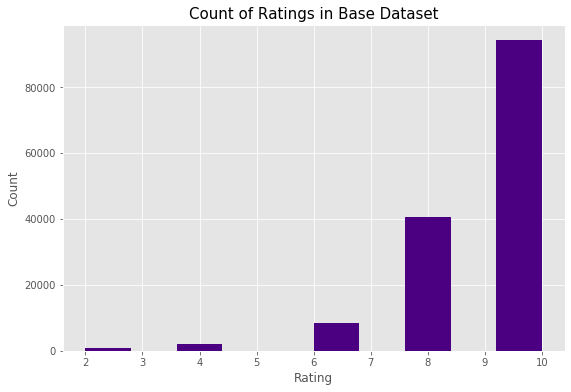

In [422]:
plt.figure(figsize=(9,6)) # base dataset

df['rating'].hist(color='indigo')

plt.title('Count of Ratings in Base Dataset', fontsize='15')
plt.xlabel('Rating')
plt.ylabel('Count');

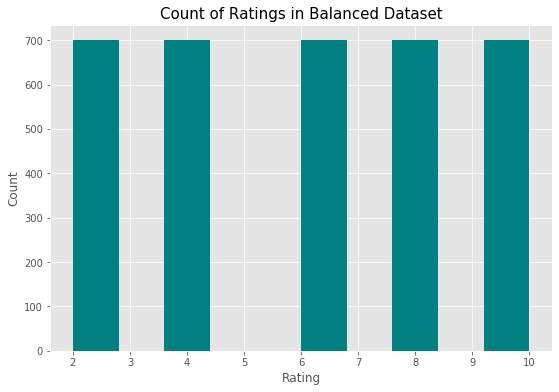

In [423]:
plt.figure(figsize=(9,6)) # after sampling to avoid imbalance and to save my computer

df_sample['rating'].hist(color='teal')

plt.title('Count of Ratings in Balanced Dataset', fontsize='15')
plt.xlabel('Rating')
plt.ylabel('Count');

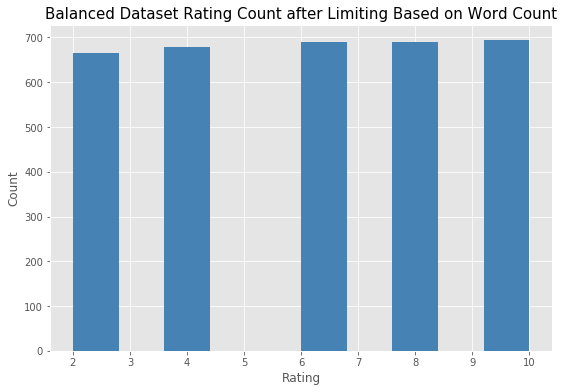

In [425]:
plt.figure(figsize=(9,6)) # After removing rows where review < 8 words

strict_df['rating'].hist(color='steelblue')

plt.title('Balanced Dataset Rating Count after Limiting Based on Word Count', fontsize='15')
plt.xlabel('Rating')
plt.ylabel('Count');

- Bar graph showing which ratings the model's having trouble with...?

In [369]:
def get_counts(data, params):
    result_dict = {}
    for param in params:
        for lst in data:
            if f"{param}_True" not in result_dict:
                result_dict[f"{param}_True"] = 0
            if f"{param}_False" not in result_dict:
                result_dict[f"{param}_False"] = 0
                
            if lst[1] == param and lst[0] == True:
                result_dict[f"{param}_True"] += 1
            elif lst[1] == param and lst[0] == False:
                result_dict[f"{param}_False"] += 1
    return result_dict

In [370]:
train_final_pred = s_gb_model.predict(Xs_train)
test_final_pred = s_gb_model.predict(Xs_test)

ys_train_array = np.array(ys_train)
ys_test_array = np.array(ys_test)

In [398]:
test_5 = []
train_5 = []

for idx, val in enumerate(test_final_pred):
    test_5.append([val < ys_test_array[idx]+.5 and val > ys_test_array[idx]-.5, ys_test_array[idx]])

for idx, val in enumerate(train_final_pred):
    train_5.append([val < ys_train_array[idx]+.5 and val > ys_train_array[idx]-.5, ys_train_array[idx]])

In [399]:
test_dict = get_counts(test_5, [2, 4, 6, 8, 10])

train_dict = get_counts(train_5, [2, 4, 6, 8, 10])

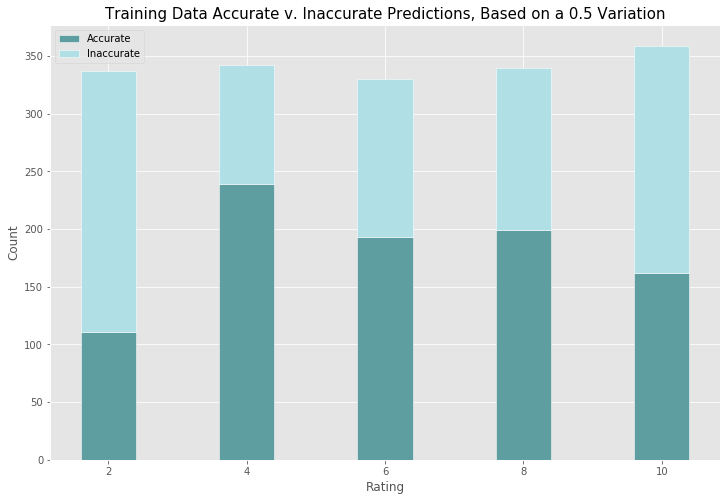

In [420]:
r = [2, 4, 6, 8, 10]
train_trues5 = [111,239,193,199,162]
train_falses5 = [226,103,137,141,197]

plt.figure(figsize=(12,8))

plt.bar(r, train_trues5, color='cadetblue', edgecolor='white', label='Accurate')
plt.bar(r, train_falses5, bottom=train_trues5, color='powderblue', edgecolor='white', label='Inaccurate')

plt.title('Training Data Accurate v. Inaccurate Predictions, Based on a 0.5 Variation', fontsize='15')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.legend();

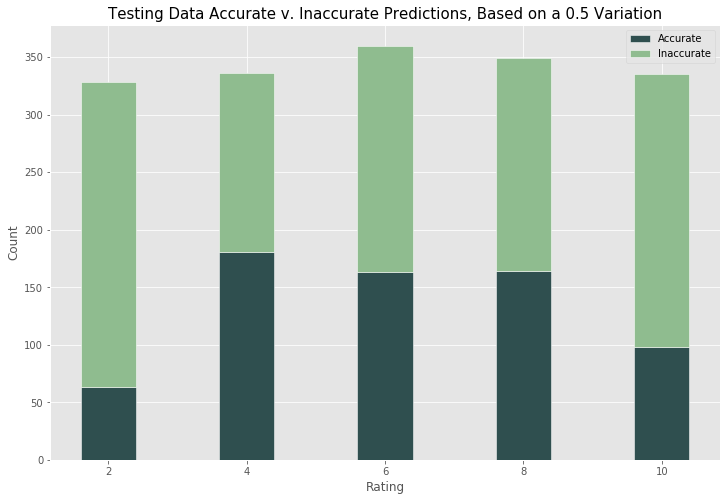

In [418]:
test_trues5 = [63,181,163,164,98]
test_falses5 = [265,155,197,185,237]

plt.figure(figsize=(12,8))

plt.bar(r, test_trues5, color='darkslategray', edgecolor='white', label='Accurate')
plt.bar(r, test_falses5, bottom=test_trues5, color='darkseagreen', edgecolor='white', label='Inaccurate')

plt.title('Testing Data Accurate v. Inaccurate Predictions, Based on a 0.5 Variation', fontsize='15')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.legend();